In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST

# Import the Fos classes we are going to use in this notebook
from fos import NotebookMeter, MemoryMeter, MultiMeter, SuperModel, Trainer

### Introduction
This notebook demonstrates how to use **Fos** to train a MNIST model. The input for this model are scans of handwritten digits (0-9) and the target is the digit that it represents. There is only one digit per image and all images have the same shape.

The first part of the script is setting up the data loaders and the model architecture. There are no specific Fos classes required here. Fos will work just fine with regular PyTorch classes like the `DataLoader` and the `nn.Module`. 

Also a custom metric like `accuracy` can be easily defined. It is a plain Python function of which the first argument is the predicted value (y) and the second arument is the target value (t). The output of the function is the calculated metric value itself.

In [2]:
def get_dataloaders():
    '''Loads the images required to train the model. First time will download them from the Internet.'''
    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    
    train_loader = DataLoader(MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=128, shuffle=True)
    
    val_loader = DataLoader(MNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=128, shuffle=False)
    
    return train_loader, val_loader


class DigitPredictor(nn.Module):
    '''A simple convolutional network for predicting the digits'''
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
                        nn.Conv2d(1, 5, kernel_size=5),
                        nn.MaxPool2d(2),
                        nn.ReLU(),
                        nn.Conv2d(5, 10, kernel_size=5),
                        nn.MaxPool2d(2),
                        nn.ReLU())
        
        self.fc = nn.Sequential(
                        nn.Linear(160, 32),
                        nn.ReLU(),
                        nn.Linear(32, n_classes))

    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(1)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

    
def accuracy(y, t):
    '''Calculates the accuracy of the predictions'''
    y = torch.argmax(y, dim=-1)
    return (y == t).float().mean().item()


### Setup PyTorch

We now get to the part where we instantiate everything. The first part is the same as any other PyTorch program. The model (predictor), optimizer and loss functions are all plain PyTorch objects with no Fos magic going on. The same holds true for the two dataloaders. If you are not yet familiar with this, there are some excellent tutorials on the [PyTorch](https://pytorch.org) website.

If you have a GPU, you can change the code below that instantiates the predictor to `DigitPredictor().to("cuda")` in order to speedup the training. However since this is a small model it will also perform well on most modern CPU's.   


In [3]:
predictor = DigitPredictor()
loss_fn   = F.nll_loss
optim     = torch.optim.Adam(predictor.parameters())
data_train, data_valid = get_dataloaders()

Processing...
Done!


## Setup Fos

The following section is where we setup the *Fos* part of the program. We start with creating some meters to capture the metrics. In this example we want to use two meters:

* `NotebookMeter` that will print the metrics in the Notebook.
* `MemoryMeter` that will just store the captured metrics in memory. 
  We will later use this to visualize the accuracy during training and validation

The `MultiMeter` is then created that includes these two meters. When the trainer forwards metrics to the MultiMeter, the MultiMeter will delegate this to these two meters. This way any arbritrary number of meters can be inlcuded in the training.

In [4]:
nbmeter = NotebookMeter()
history = MemoryMeter()
meter   = MultiMeter(nbmeter, history)

When you create a SuperModel you need to always provide the predictor (the model you want to train) and the loss function. But optionally you can pass extra metrics functions to the supermodel initializer as a dictionary. 

The key is the name that will be used to publish the metric and the value is the actual metric function itself. For training phase the metric will be published under the name provided. And for the validation phase it will be prepended with `val_` in order to be able to distinguish the two. So in this case there will be `acc` and `val_acc` metrics displayed.

In [5]:
model   = SuperModel(predictor, loss_fn, metrics={"acc":accuracy})
trainer = Trainer(model, optim, meter)

### Run the training

Remains running the trainer for a number of epochs. When we run the trainer, we supply both the data for training and validation phases and specify for how many epochs we want to run this training. If the validation data is not provided, the validation phase is skipped all together. And if no value for the numper of epochs is provided, 1 epoch is assumed.

You should see a validation accuracy of above 98% after the first 5 epochs. Since the trainer keeps track of the state, you can rerun the cell multiple times and it just continues where it left off (the epoch and step counters don't reset). This allows for a iterative development approach in for example a Jupyter notebook.

In [6]:
trainer.run(data_train, data_valid, 10)

[  0:   469] loss=0.41374 acc=0.88320 val_loss=0.12012 val_acc=0.96479 : 100%|██████████|00:15<00:00
[  1:   938] loss=0.11817 acc=0.96411 val_loss=0.09280 val_acc=0.97152 : 100%|██████████|00:15<00:00
[  2:  1407] loss=0.08805 acc=0.97365 val_loss=0.07288 val_acc=0.97627 : 100%|██████████|00:15<00:00
[  3:  1876] loss=0.07055 acc=0.97792 val_loss=0.06490 val_acc=0.98101 : 100%|██████████|00:15<00:00
[  4:  2345] loss=0.06265 acc=0.98094 val_loss=0.05732 val_acc=0.98141 : 100%|██████████|00:15<00:00
[  5:  2814] loss=0.05487 acc=0.98278 val_loss=0.05123 val_acc=0.98339 : 100%|██████████|00:15<00:00
[  6:  3283] loss=0.04886 acc=0.98519 val_loss=0.04685 val_acc=0.98497 : 100%|██████████|00:15<00:00
[  7:  3752] loss=0.04503 acc=0.98605 val_loss=0.04545 val_acc=0.98576 : 100%|██████████|00:15<00:00
[  8:  4221] loss=0.04171 acc=0.98683 val_loss=0.04634 val_acc=0.98527 : 100%|██████████|00:14<00:00
[  9:  4690] loss=0.03774 acc=0.98801 val_loss=0.04326 val_acc=0.98625 : 100%|██████████|00

## Visualization
The memory meter captured the metrics and can now be used to plot some graphs. The `get_history` method returns both the steps (X axis) and values (Y axis) of a particular metric. 

This result can be easily passed as an argument to `plot` method of pyplot. So even when metrics are captured at different steps in the learning, they can be plotted in the same graph.

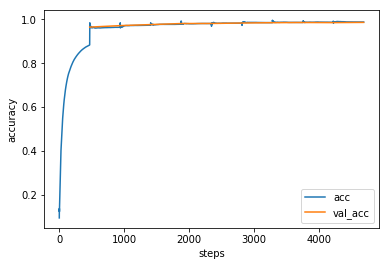

In [8]:
from matplotlib import pyplot as plt

metrics = ["acc", "val_acc"]
for metric in metrics:
    plt.plot(*history.get_history(metric))

plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend(metrics);

### Save and restore training sessions

If you want to save the trainer and its state, use the `trainer.save()` method. You can optionally specify a file name or let otherwise a directory and filename be generated for you. The trainer will save the following state:

1. The SuperModel state (including the underlying predictor model state)
2. The Trainer state (including the optimizer state)


In [ ]:
trainer.save("my_best_model.pty")

And again if at later stage you want to continue where you left off or perhaps revert back to a previously saved version, just load the state from one of the files.

In [ ]:
trainer.load("my_best_model.pty")